<a href="https://colab.research.google.com/github/prakhar-srivastav/Q-A-Bot-/blob/master/Q_A_bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')
import pickle
import numpy as np

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.listdir('drive/My Drive/Q A Bot/Dataset/train_qa.txt')

NotADirectoryError: ignored

In [0]:
with open("drive/My Drive/Q A Bot/Dataset/train_qa.txt", "rb") as fp:   
    train_data =  pickle.load(fp)

In [0]:
with open("drive/My Drive/Q A Bot/Dataset/test_qa.txt", "rb") as fp:   
    test_data =  pickle.load(fp)

In [0]:
train_data[0]

(['Mary',
  'moved',
  'to',
  'the',
  'bathroom',
  '.',
  'Sandra',
  'journeyed',
  'to',
  'the',
  'bedroom',
  '.'],
 ['Is', 'Sandra', 'in', 'the', 'hallway', '?'],
 'no')

In [0]:
vocab = set()

In [0]:
all_data = test_data + train_data

In [0]:
for story, question , answer in all_data:
    vocab = vocab.union(set(story))
    vocab = vocab.union(set(question))

In [0]:
vocab.add('no')
vocab.add('yes')

In [0]:
vocab_size = len(vocab) + 1

In [0]:
max_story_len = max([len(data[0]) for data in all_data])
max_story_len


156

In [0]:
max_question_len = max([len(data[1]) for data in all_data])
max_question_len

6

In [0]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [0]:
tokenizer = Tokenizer(filters=[])
tokenizer.fit_on_texts(vocab)

In [0]:
tokenizer.word_index

{'.': 30,
 '?': 21,
 'apple': 19,
 'back': 20,
 'bathroom': 31,
 'bedroom': 3,
 'daniel': 5,
 'discarded': 32,
 'down': 24,
 'dropped': 1,
 'football': 2,
 'garden': 4,
 'got': 36,
 'grabbed': 25,
 'hallway': 27,
 'in': 11,
 'is': 17,
 'john': 23,
 'journeyed': 12,
 'kitchen': 28,
 'left': 10,
 'mary': 14,
 'milk': 35,
 'moved': 26,
 'no': 8,
 'office': 15,
 'picked': 16,
 'put': 33,
 'sandra': 13,
 'the': 29,
 'there': 22,
 'to': 7,
 'took': 34,
 'travelled': 18,
 'up': 37,
 'went': 6,
 'yes': 9}

In [0]:
train_story_text = []
train_question_text = []
train_answers = []

for story,question,answer in train_data:
    train_story_text.append(story)
    train_question_text.append(question)

In [0]:
import json
data=tokenizer.word_index

with open('data.json', 'w') as fp:
    json.dump(data, fp)

In [0]:
train_story_seq = tokenizer.texts_to_sequences(train_story_text)

In [0]:
def vectorize_stories(data, word_index=tokenizer.word_index, max_story_len=max_story_len,max_question_len=max_question_len):
    
    
    
    X = []
    Xq = []
    Y = []
    
  
    for story, query, answer in data:
        
        
        x = [word_index[word.lower()] for word in story]
        xq = [word_index[word.lower()] for word in query]  
        y = np.zeros(len(word_index) + 1)
        
        y[word_index[answer]] = 1
        X.append(x)
        Xq.append(xq)
        Y.append(y)
        
    return (pad_sequences(X, maxlen=max_story_len),pad_sequences(Xq, maxlen=max_question_len), np.array(Y))

In [0]:
inputs_train, queries_train, answers_train = vectorize_stories(train_data)

In [0]:
inputs_test, queries_test, answers_test = vectorize_stories(test_data)

In [0]:
from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout
from keras.layers import add, dot, concatenate
from keras.layers import LSTM

In [0]:
input_sequence = Input((max_story_len,))
question = Input((max_question_len,))

In [0]:
#Encoder M
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,output_dim=64))
input_encoder_m.add(Dropout(0.3))

In [0]:
#Encoder C
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,output_dim=max_question_len))
input_encoder_c.add(Dropout(0.3) )

In [0]:
#Question Encoder
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=64,
                               input_length=max_question_len))
question_encoder.add(Dropout(0.3))

In [0]:
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

In [0]:
match = dot([input_encoded_m, question_encoded], axes=(2, 2))
match = Activation('softmax')(match)

In [0]:

response = add([match, input_encoded_c])  
response = Permute((2, 1))(response) 

In [0]:
answer = concatenate([response, question_encoded])

In [0]:
answer

<tf.Tensor 'concatenate_1/concat:0' shape=(None, 6, 220) dtype=float32>

In [0]:
answer = LSTM(32)(answer)

In [0]:
answer = Dropout(0.5)(answer)
answer = Dense(vocab_size)(answer)

In [0]:
answer = Activation('softmax')(answer)

In [0]:
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 156)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 6)            0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       multiple             2432        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 6, 64)        2432        input_2[0][0]                    
____________________________________________________________________________________________

In [0]:
history = model.fit([inputs_train, queries_train], answers_train,batch_size=32,epochs=120,validation_data=([inputs_test, queries_test], answers_test))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 10000 samples, validate on 1000 samples
Epoch 1/120
10000/10000 [==============================] - 8s 770us/step - loss: 0.8488 - accuracy: 0.4936 - val_loss: 0.7022 - val_accuracy: 0.4970
Epoch 2/120
10000/10000 [==============================] - 5s 509us/step - loss: 0.7001 - accuracy: 0.4990 - val_loss: 0.6944 - val_accuracy: 0.5030
Epoch 3/120
10000/10000 [==============================] - 6s 562us/step - loss: 0.6954 - accuracy: 0.5015 - val_loss: 0.6937 - val_accuracy: 0.4970
Epoch 4/120
10000/10000 [==============================] - 5s 546us/step - loss: 0.6954 - accuracy: 0.4968 - val_loss: 0.6932 - val_accuracy: 0.5030
Epoch 5/120
10000/10000 [==============================] - 6s 551us/step - loss: 0.6945 - accuracy: 0.4956 - val_loss: 0.6977 - val_accuracy: 0.4970
Epoch 6/120
10000/10000 [==============================] - 5s 531us/step - loss: 0.6945 - accuracy: 0.5073 - val_loss: 0.6934 - val_accuracy: 0.4970
Epoch 7/120
10000/10000 [==============================] 

In [0]:
filename = 'drive/My Drive/Q A Bot/chatbot_120_epochs.h5'
model.save(filename)

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


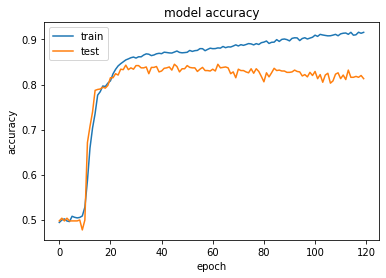

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
model.load_weights(filename)
pred_results = model.predict(([inputs_test, queries_test]))



In [0]:
story =' '.join(word for word in test_data[0][0])
print(story)

Mary got the milk there . John moved to the bedroom .


In [0]:
query = ' '.join(word for word in test_data[0][1])
print(query)

Is John in the kitchen ?


In [0]:
print("True Test Answer from Data is:",test_data[0][2])

True Test Answer from Data is: no


In [0]:
np.argmax(pred_results[0])

8

In [0]:
val_max = np.argmax(pred_results[0])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

print("Predicted answer is: ", k)
print("Probability of certainty was: ", pred_results[0][val_max])

Predicted answer is:  no
Probability of certainty was:  0.9999764


In [0]:
my_story = "John left the kitchen . Sandra dropped the football in the garden ."
my_story.split()

['John',
 'left',
 'the',
 'kitchen',
 '.',
 'Sandra',
 'dropped',
 'the',
 'football',
 'in',
 'the',
 'garden',
 '.']

In [0]:
my_question = "Is the football in the garden ?"
my_question.split()

['Is', 'the', 'football', 'in', 'the', 'garden', '?']

In [0]:
mydata = [(my_story.split(),my_question.split(),'yes')]

In [0]:
my_story,my_ques,my_ans = vectorize_stories(mydata)

In [0]:
pred_results = model.predict(([ my_story, my_ques]))

In [0]:
val_max = np.argmax(pred_results[0])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

print("Predicted answer is: ", k)
print("Probability of certainty was: ", pred_results[0][val_max])

Predicted answer is:  yes
Probability of certainty was:  0.7965055
